# 🎓 Educational Version - No Streamlit Required

This section recreates the traffic light detection app as a pure Python notebook for learning purposes.
No need for Streamlit - just run the cells!

In [ ]:
# install reqs
!pip install streamlit torch torchvision torchaudio opencv-python numpy pillow ipywidgets

In [53]:
# Import libraries for notebook visualization
import torch
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display, HTML
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Set matplotlib to display images inline
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [54]:
# Load YOLOv5 model (will use cached version if available)
print("🔄 Loading YOLOv5 model...")

# Fix for PyTorch 2.6+ weights_only=True default behavior
# Allow YOLOv5 custom classes to be loaded safely
import torch.serialization
try:
    # Dynamically import YOLOv5 classes after repo is loaded
    import sys
    import os
    yolo_path = torch.hub.get_dir() + '/ultralytics_yolov5_master'
    if yolo_path not in sys.path:
        sys.path.insert(0, yolo_path)
    
    from models.yolo import Model
    from models.common import Conv, Bottleneck, SPP, DWConv, Focus, BottleneckCSP, Concat
    from utils.general import check_img_size
    
    # Add YOLOv5 classes to safe globals
    torch.serialization.add_safe_globals([Model, Conv, Bottleneck, SPP, DWConv, Focus, BottleneckCSP, Concat])
    print("✅ YOLOv5 classes registered as safe globals")
except Exception as e:
    print(f"⚠️ Could not register safe globals: {e}")
    print("   Continuing anyway - model loading will handle it...")

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=False)
print("✅ Model loaded successfully!")
print(f"📊 Can detect {len(model.names)} object types")

🔄 Loading YOLOv5 model...
✅ YOLOv5 classes registered as safe globals


Using cache found in C:\Users\LENOVO/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-2-7 Python-3.13.7 torch-2.6.0+cpu CPU

Fusing layers... 
Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


✅ Model loaded successfully!
📊 Can detect 80 object types


In [22]:
# Color Detection Function (Educational Version with Visualization)
def detect_traffic_light_color_educational(image, box, show_process=True):
    """
    Detect traffic light color with educational visualizations.
    
    Args:
        image: RGB image array
        box: Bounding box [x1, y1, x2, y2]
        show_process: If True, displays intermediate steps
    
    Returns:
        Detected color string
    """
    # Step 1: Crop the traffic light region
    x1, y1, x2, y2 = map(int, box)
    cropped_image = image[y1:y2, x1:x2]
    
    if show_process:
        print(f"📐 Bounding Box: x1={x1}, y1={y1}, x2={x2}, y2={y2}")
        print(f"📏 Cropped size: {cropped_image.shape}")
    
    # Step 2: Convert to HSV
    hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2HSV)
    
    # Step 3: Define color ranges
    red_lower1 = np.array([0, 70, 50])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([170, 70, 50])
    red_upper2 = np.array([180, 255, 255])
    
    green_lower = np.array([40, 40, 40])
    green_upper = np.array([80, 255, 255])
    
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    
    # Step 4: Create masks and count pixels
    red_mask1 = cv2.inRange(hsv_image, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv_image, red_lower2, red_upper2)
    red_mask = red_mask1 | red_mask2
    red_pixels = cv2.countNonZero(red_mask)
    
    green_mask = cv2.inRange(hsv_image, green_lower, green_upper)
    green_pixels = cv2.countNonZero(green_mask)
    
    yellow_mask = cv2.inRange(hsv_image, yellow_lower, yellow_upper)
    yellow_pixels = cv2.countNonZero(yellow_mask)
    
    # Visualize the process
    if show_process:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Row 1: Original, HSV, and masks
        axes[0, 0].imshow(cropped_image)
        axes[0, 0].set_title('1. Cropped Traffic Light (RGB)', fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(hsv_image)
        axes[0, 1].set_title('2. Converted to HSV', fontsize=12, fontweight='bold')
        axes[0, 1].axis('off')
        
        # Show pixel counts
        axes[0, 2].bar(['Red', 'Yellow', 'Green'], [red_pixels, yellow_pixels, green_pixels],
                       color=['red', 'yellow', 'green'], alpha=0.7)
        axes[0, 2].set_title('3. Pixel Counts', fontsize=12, fontweight='bold')
        axes[0, 2].set_ylabel('Number of Pixels')
        axes[0, 2].grid(axis='y', alpha=0.3)
        
        # Row 2: Color masks
        axes[1, 0].imshow(red_mask, cmap='Reds')
        axes[1, 0].set_title(f'Red Mask ({red_pixels} pixels)', fontsize=10)
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(yellow_mask, cmap='YlOrBr')
        axes[1, 1].set_title(f'Yellow Mask ({yellow_pixels} pixels)', fontsize=10)
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(green_mask, cmap='Greens')
        axes[1, 2].set_title(f'Green Mask ({green_pixels} pixels)', fontsize=10)
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Step 5: Determine dominant color
    max_pixels = max(red_pixels, green_pixels, yellow_pixels)
    
    if max_pixels == 0:
        color = 'Unknown'
    elif max_pixels == red_pixels:
        color = 'RED'
    elif max_pixels == green_pixels:
        color = 'GREEN'
    else:
        color = 'YELLOW'
    
    print(f"\n🎯 Detection Result: {color} LIGHT")
    print(f"   Red: {red_pixels} | Yellow: {yellow_pixels} | Green: {green_pixels}")
    
    return color.lower()

print("✅ Color detection function defined!")

✅ Color detection function defined!


## 📸 Load and Process Your Image

Replace the path below with your image file path, or use a file upload widget.

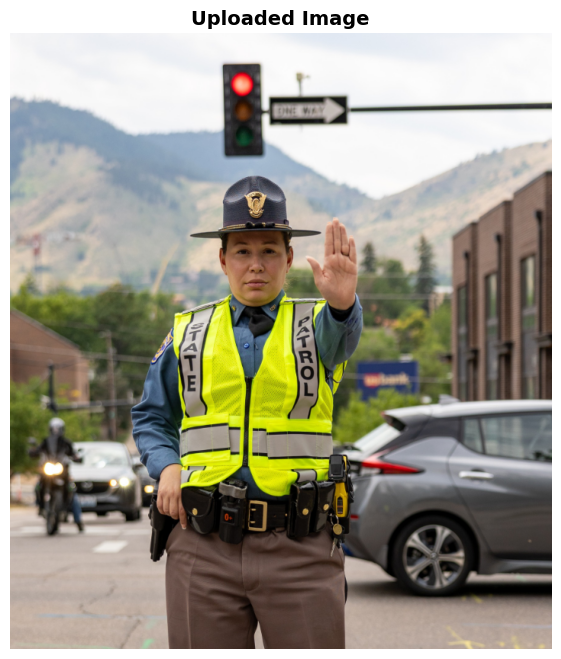

✅ Image loaded: (808, 710, 4)


In [73]:
# specify image path directly
# Uncomment and modify the line below to use a file path instead

image_path = r'D:\Work\TECH\Route\Projects\CV\Traffic_Light_Detection\Image_examples\5.png'
img = Image.open(image_path)
image_array = np.array(img)



# Display the uploaded image
plt.figure(figsize=(10, 8))
plt.imshow(image_array)
plt.title('Uploaded Image', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()
print(f"✅ Image loaded: {image_array.shape}")

## 🔍 Perform Traffic Light Detection

In [74]:
# Run YOLOv5 detection
if 'image_array' in locals():
    print("🔄 Running object detection...")
    detection_result = model(image_array)
    
    # Extract bounding boxes
    boxes = detection_result.xyxy[0].numpy()
    
    print(f"✅ Detection complete! Found {len(boxes)} objects")
    print(f"📊 Detection details:\n")
    
    # Create list to store all objects
    objects_list = []
    
    # Show detection summary
    for i, box in enumerate(boxes):
        label = detection_result.names[int(box[5])]
        confidence = box[4]
        
        # Create a new dictionary for each object
        objects_dic = {
            'Object': f'Object {i+1}',
            'Label': label,
            'Confidence (%)': round(float(confidence), 2) * 100
        }
        objects_list.append(objects_dic)
    
    # Create DataFrame from list of dictionaries
    obj_df = pd.DataFrame(objects_list)
    display(obj_df)
else:
    print("❌ No image loaded. Please load an image first.")

🔄 Running object detection...
✅ Detection complete! Found 9 objects
📊 Detection details:



,Object,Label,Confidence (%)
0,Object 1,car,91.0
1,Object 2,traffic light,84.0
2,Object 3,car,79.0
3,Object 4,person,70.0
4,Object 5,person,68.0
5,Object 6,bicycle,47.0
6,Object 7,motorcycle,44.0
7,Object 8,tie,34.0
8,Object 9,car,32.0



🚦 TRAFFIC LIGHT ANALYSIS

────────────────────────────────────────────────────────────
🚦 Traffic Light #1 (Confidence: 84.07%)
────────────────────────────────────────────────────────────
📐 Bounding Box: x1=278, y1=38, x2=333, y2=165
📏 Cropped size: (127, 55, 4)


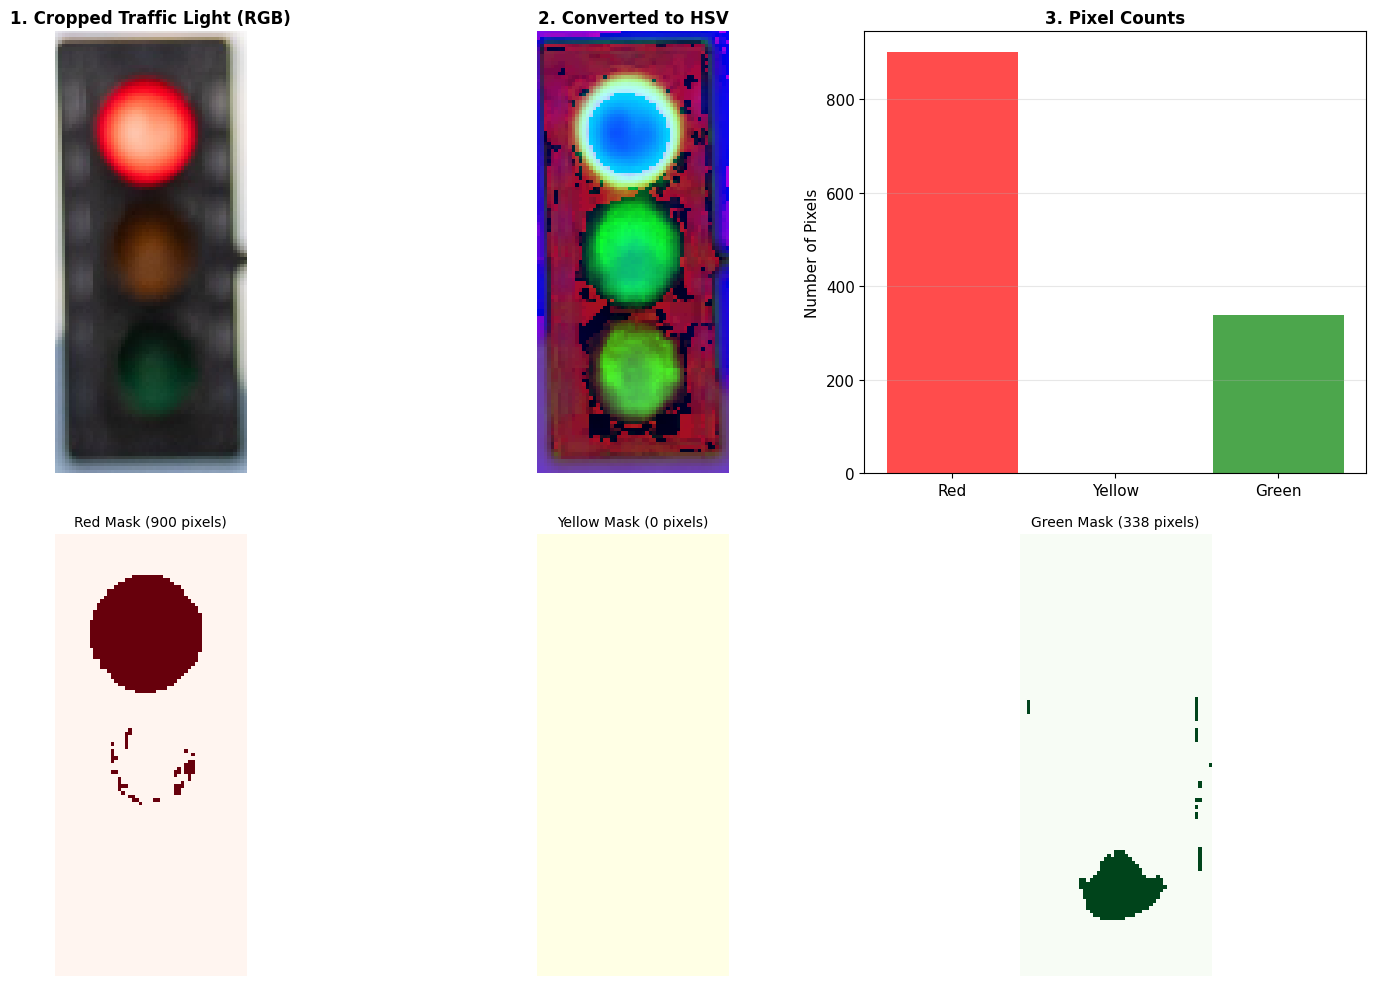


🎯 Detection Result: RED LIGHT
   Red: 900 | Yellow: 0 | Green: 338

📊 SUMMARY
Total traffic lights detected: 1
🔴 Red lights: 1
🟡 Yellow lights: 0
🟢 Green lights: 0


In [75]:
# Process each traffic light with detailed visualization
if 'detection_result' in locals():
    traffic_light_count = 0
    colors_detected = []
    
    print("\n" + "="*60)
    print("🚦 TRAFFIC LIGHT ANALYSIS")
    print("="*60)
    
    for box in boxes:
        label = detection_result.names[int(box[5])]
        confidence = box[4]
        
        if label == 'traffic light':
            traffic_light_count += 1
            print(f"\n{'─'*60}")
            print(f"🚦 Traffic Light #{traffic_light_count} (Confidence: {confidence:.2%})")
            print(f"{'─'*60}")
            
            # Detect color with visualization
            color = detect_traffic_light_color_educational(image_array, box[:4], show_process=True)
            colors_detected.append(color)
    
    # Summary
    print(f"\n{'='*60}")
    print(f"📊 SUMMARY")
    print(f"{'='*60}")
    print(f"Total traffic lights detected: {traffic_light_count}")
    print(f"🔴 Red lights: {colors_detected.count('red')}")
    print(f"🟡 Yellow lights: {colors_detected.count('yellow')}")
    print(f"🟢 Green lights: {colors_detected.count('green')}")
    print(f"{'='*60}")
else:
    print("❌ No detections available. Run detection first.")

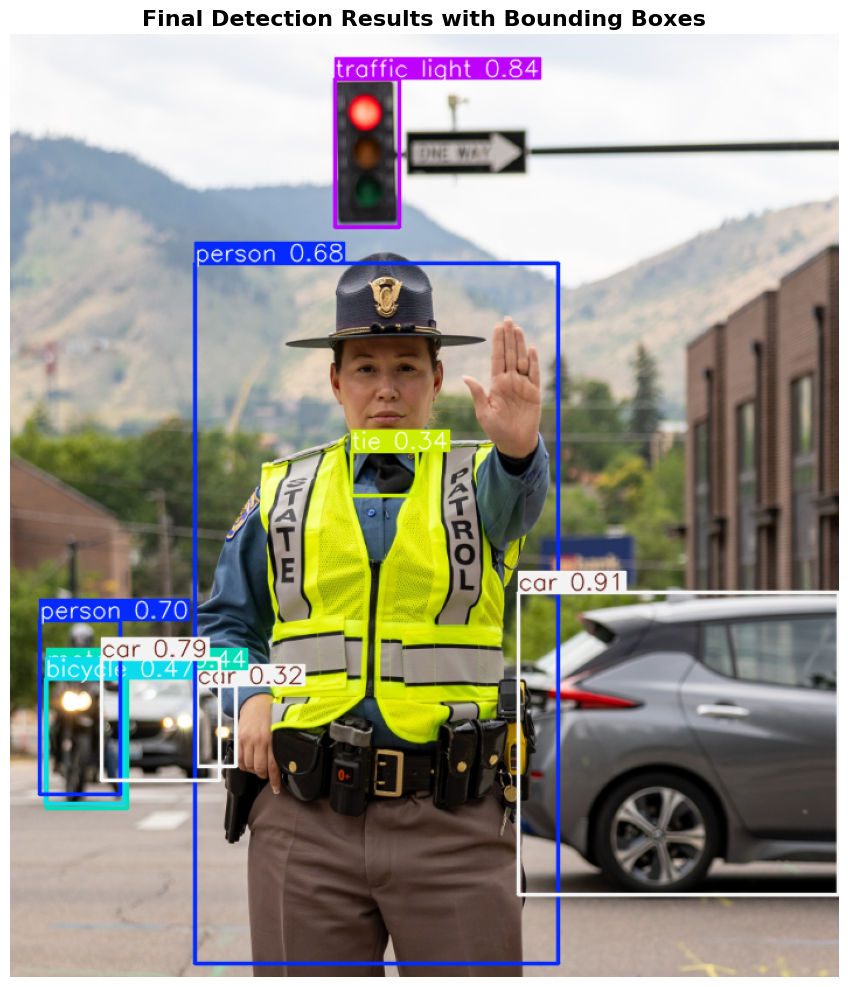

✅ Detection visualization complete!


In [76]:
# Visualize final results with bounding boxes
if 'detection_result' in locals():
    # Create annotated image
    annotated_img = detection_result.render()[0]
    
    # Display with matplotlib
    plt.figure(figsize=(14, 10))
    plt.imshow(annotated_img)
    plt.title('Final Detection Results with Bounding Boxes', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("✅ Detection visualization complete!")
else:
    print("❌ No detections to visualize.")

## Streamlit APP

In [ ]:
%%writefile ED_APP.py
import streamlit as st
import torch
from PIL import Image
import cv2
import numpy as np

#load model YOLOV5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

st.title('Traffic Light Detection Application')

upload = st.file_uploader('Please, Upload an Image', type = ['png', 'jpeg', 'jpg'])

def object_detection(image,box,label):
    #crop image
    x1, y1, x2, y2 = map(int, box)
    st.write(f'Bounding Box Coordinates: x1={x1}, y1={y1}, x2={x2}, y2={y2}')
    cropped_image = image[y1:y2, x1:x2] #height, width    
    st.image(cropped_image, caption = F'Cropped Object: {label}')

#define a function ro detect colors
def Color_detection(image, box):
    #crop image
    x1, y1, x2, y2 = map(int, box)
    st.write(f'Bounding Box Coordinates: x1={x1}, y1={y1}, x2={x2}, y2={y2}')
    cropped_image = image[y1:y2, x1:x2] #height, width

    #convert image to HSV 
    hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2HSV)
    st.image(hsv_image, caption = 'Cropped Traffic Light in HSV')
    #define color ranges for red, green , yellow
    red_lower1 = np.array([0,70,50])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([170,70,50])
    red_upper2 = np.array([180, 255, 255])

    green_lower = np.array([40,40,40])
    green_upper = np.array([80, 255, 255])

    yellow_lower = np.array([20,100,100])
    yellow_upper = np.array([30, 255, 255])


    #check for red, green , yellow
    red_mask1 = cv2.inRange(hsv_image, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv_image, red_lower2, red_upper2)
    red_mask = red_mask1 | red_mask2
    red_pixels = cv2.countNonZero(red_mask)

    green_mask = cv2.inRange(hsv_image, green_lower, green_upper)
    green_pixles = cv2.countNonZero(green_mask)

    yellow_mask = cv2.inRange(hsv_image, yellow_lower, yellow_upper)
    yellow_pixles = cv2.countNonZero(yellow_mask)

    #determine color for traffic light
    if max(red_pixels, green_pixles, yellow_pixles) == red_pixels:
        return 'red'
    elif max(red_pixels, green_pixles, yellow_pixles) == green_pixles:
        return 'green'
    elif max(red_pixels, green_pixles, yellow_pixles) == yellow_pixles:
        return 'yellow'
    else:
        return 'Unknown Color' 
    

if upload is not None:
    img = Image.open(upload)
    image_array = np.array(img)
    st.image(image_array, caption = 'Uploaded Image...', use_container_width = True)

    #perform detection
    detection_result = model(image_array)
    st.write("detection_result")
    st.write(detection_result)
    st.write("------------------------------------------")
    st.write("detection_result.pandas().xyxy")
    st.write(detection_result.pandas().xyxy)
    st.write("------------------------------------------")
    st.write("detection_result.pandas().xyxy[0]",detection_result.pandas().xyxy[0])
    #get bounding box
    boxes = detection_result.xyxy[0].numpy()
    st.write("------------------------------------------")
    st.write("detection_result.xyxy[0].numpy()")
    st.write("------------------------------------------")
    st.write("boxes",boxes)
    #display result
    for box in boxes:
        st.write("box",box)
        label = detection_result.names[int(box[5])]
        st.write("Label:", label)
        if label == 'traffic light':
            color = Color_detection(image_array, box[:4])
            st.write(f'Detected Traffic Light Color: {color}')
        else:
            object_detection(image_array, box[:4],label)
            st.write(label)

    st.image(detection_result.render()[0], use_container_width = True)